# Recurrent Neural Networks

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('GnBu_d')
sns.set_style('whitegrid')

## Data Loading

In [2]:
milk = pd.read_csv('Data/Monthly Milk Production.csv', index_col='Month')

In [3]:
milk.head()

,Milk Production
Month,
1962-01-01 01:00:00,589.0
1962-02-01 01:00:00,561.0
1962-03-01 01:00:00,640.0
1962-04-01 01:00:00,656.0
1962-05-01 01:00:00,727.0


In [4]:
milk.describe()

,Milk Production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


In [5]:
milk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 168 entries, 1962-01-01 01:00:00 to 1975-12-01 01:00:00
Data columns (total 1 columns):
Milk Production    168 non-null float64
dtypes: float64(1)
memory usage: 2.6+ KB


## Exploratory Data Analysis

In [6]:
milk.index = pd.to_datetime(milk.index)

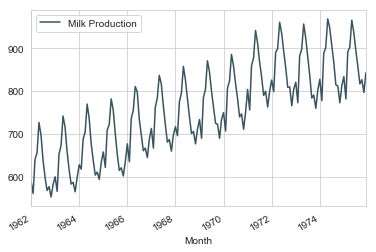

In [8]:
milk.plot();

## Data Preprocessing
### Splitting Data

In [47]:
X_train = milk.head(156).values
X_test = milk.tail(12).values

### Scaling Data

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [49]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modeling
### Defining Parameters

In [50]:
num_inputs = 1
num_time_steps = 12
num_neurons = 100
num_outputs = 1

learning_rate = 0.001 

### Defining Placeholders

In [54]:
tf.reset_default_graph()

with tf.name_scope('inputs'):
    X = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_inputs], name='X')
    y = tf.placeholder(tf.float32, shape=[None, num_time_steps, num_outputs], name='y')

### Defining Layers

In [55]:
with tf.name_scope('rnn'):
    cell = tf.contrib.rnn.OutputProjectionWrapper(
        tf.contrib.rnn.BasicLSTMCell(num_units=num_neurons, activation=tf.nn.relu),
        output_size=num_outputs)
    outputs, states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)

### Defining Loss Function

In [56]:
with tf.name_scope('loss'):
    loss = tf.reduce_mean(tf.square(outputs - y))

### Training Model

In [57]:
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
    training_op = optimizer.minimize(loss)

### Running Model

In [58]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [64]:
def next_batch(X_train, batch_size, steps):
    rand_start = np.random.randint(0, len(X_train) - steps) 
    y_batch = np.array(X_train[rand_start: rand_start + steps + 1]).reshape(1, steps + 1)
    return y_batch[:, :-1].reshape(-1, steps, 1), y_batch[:, 1:].reshape(-1, steps, 1) 

In [65]:
n_iterations = 4000
batch_size = 1

with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch, y_batch = next_batch(X_train_scaled, batch_size, num_time_steps)
        sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X: X_batch, y: y_batch})
            print(iteration, '\tMSE:', mse)
        save_path = saver.save(sess, './Models/tf_rnn_example.ckpt')

0 	MSE: 0.0948433
100 	MSE: 0.021107668
200 	MSE: 0.014839022
300 	MSE: 0.0071282363
400 	MSE: 0.008346978
500 	MSE: 0.009279608
600 	MSE: 0.005621565
700 	MSE: 0.009513958
800 	MSE: 0.008244968
900 	MSE: 0.008500063
1000 	MSE: 0.0050741523
1100 	MSE: 0.008510666
1200 	MSE: 0.0032719534
1300 	MSE: 0.010819125
1400 	MSE: 0.0075363177
1500 	MSE: 0.0074852477
1600 	MSE: 0.0075156055
1700 	MSE: 0.0063036424
1800 	MSE: 0.0024920525
1900 	MSE: 0.0034056127
2000 	MSE: 0.00732947
2100 	MSE: 0.008253871
2200 	MSE: 0.009622886
2300 	MSE: 0.0031134274
2400 	MSE: 0.0038502284
2500 	MSE: 0.0009541419
2600 	MSE: 0.0044237957
2700 	MSE: 0.0048939236
2800 	MSE: 0.00313357
2900 	MSE: 0.0028846937
3000 	MSE: 0.0022618598
3100 	MSE: 0.0019119418
3200 	MSE: 0.0017552724
3300 	MSE: 0.0026333996
3400 	MSE: 0.007628825
3500 	MSE: 0.0054316283
3600 	MSE: 0.0039740293
3700 	MSE: 0.0016019121
3800 	MSE: 0.0034228575
3900 	MSE: 0.0025733886


### Predicting Data

In [68]:
with tf.Session() as sess:
    saver.restore(sess, './Models/tf_rnn_example.ckpt')
    train_seed = list(X_train_scaled[-12:])
    for iteration in range(12):
        X_batch = np.array(train_seed[-num_time_steps:]).reshape(1, num_time_steps, 1)
        y_pred = sess.run(outputs, feed_dict={X: X_batch})
        train_seed.append(y_pred[0, -1, 0])

INFO:tensorflow:Restoring parameters from ./Models/tf_rnn_example.ckpt


In [69]:
train_seed

[array([0.66105769]),
 array([0.54086538]),
 array([0.80769231]),
 array([0.83894231]),
 array([1.]),
 array([0.94711538]),
 array([0.85336538]),
 array([0.75480769]),
 array([0.62980769]),
 array([0.62259615]),
 array([0.52884615]),
 array([0.625]),
 0.6013206,
 0.5833429,
 0.70261514,
 0.58544356,
 0.7854097,
 0.810999,
 0.85315835,
 0.76829475,
 0.6438923,
 0.57593566,
 0.4703027,
 0.5388366]

In [71]:
results = scaler.inverse_transform(np.array(train_seed[12:]).reshape(12, 1))

In [83]:
milk_test = pd.DataFrame(X_test, columns=milk.columns, index=milk.tail(12).index)
milk_test['Generated'] = results

In [84]:
milk_test

,Milk Production,Generated
Month,,
1975-01-01 01:00:00,834.0,803.149353
1975-02-01 01:00:00,782.0,795.670654
1975-03-01 01:00:00,892.0,845.287903
1975-04-01 01:00:00,903.0,796.544495
1975-05-01 01:00:00,966.0,879.730408
1975-06-01 01:00:00,937.0,890.375549
1975-07-01 01:00:00,896.0,907.913879
1975-08-01 01:00:00,858.0,872.610596
1975-09-01 01:00:00,817.0,820.859192


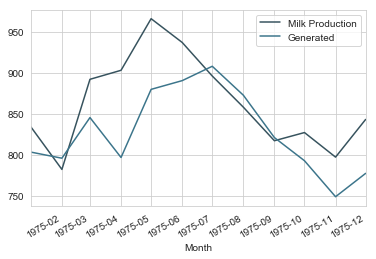

In [85]:
milk_test.plot();